In [6]:
import os
os.chdir(r'C:\Users\YbII Cobra\Documents\YbII')

import numpy as np
import matplotlib.pyplot as plt

# Fitting Module
import lmfit
from lmfit.models import gaussian2d

# Image Processing Module
import imageio
import matplotlib.pyplot as plt
from scipy import ndimage

from src.functions.math import func as mathf
from src.functions.optics import func as optf
from src.constants import const

import os
os.chdir(r'C:\Users\YbII Cobra\Documents\YbII')

# p is the measured power per beam before any VP, w1 and w2 are the beam waist radii
# s0 = 2 * (I_0 * T + I_0 * T ** 3) / I_sat
def getS0(p, w1=0.329e-2, w2=0.866e-2):
    return p / (np.pi * w1 * w2 / 2) * (0.915 + 0.915 ** 3) / const.Isat_1s0_1p1

# probability of the atom being in the excited state (from Eva Casotti's thesis)
# f is frequency of the cooling beam
# p is the measured power per beam before any VP
def rho(f, p):
    return getS0(p) / 2 / (1 + getS0(p) + (2 * (f - const.w0_1s0_1p1_32) / const.gamma_1s0_1p1) ** 2)

# sum up the pixel values in the region of interest
# x0, y0, wx, wy are the parameters of the Gaussian fit
# img_res is the background-subtracted image data
# f is frequency of the cooling beam
# p is the measured power per beam before any VP
# d0 is the image distance from the MOT to the first lens
def getAtomNumber(x0, y0, wx, wy, img, t_exp, f, p, d0):
    x0 = int(x0)
    y0 = int(y0)
    wx = int(wx)
    wy = int(wy)
    I_sum = np.sum(img[y0-wy:y0+wy, x0-wx:x0+wx])

    ppi = 2800 / 0.46 / 255 # photon per pixel per intensity
    eff = (0.0254/2) ** 2 / 4 / d0 ** 2 # collection efficiency of the imaging setup, assuming using 1 inch lens
    gamma_tot = I_sum * ppi / eff / t_exp # total photon emission rate
    gamma_atom = const.gamma_1s0_1p1 * rho(f, p) # photon emission rate of a single atom
    print(rho(f, p))
    return gamma_tot / gamma_atom

# get the number of imaged atoms
# img is the MOT image data, img_bg is the background image data
# t_exp is the exposure time of the camera
# f is frequency of the cooling beam
# p is the measured power per beam before any VP
def getImagedAtomNumber(img, img_bg, t_exp, f, p, d0):

    img_res = np.array(img, dtype=float) - np.array(img_bg, dtype=float)
    # img_res = np.vectorize(lambda x, y: 0 if x > y else y - x)(img_bg, img)

    img_res[img_res < 0] = 0

    # img_res = ndimage.rotate(img_res, -10, reshape=False)

    img_res = ndimage.rotate(img_res, -60, reshape=False)

    x_rg = np.arange(0, img_res.shape[1])
    y_rg = np.arange(0, img_res.shape[0])

    x_data = np.max(img_res, axis=0)
    y_data = np.max(img_res, axis=1)
    # x0 = 1600
    # y0 = 1400
    # x_data = img_res[y0, :]
    # y_data = img_res[:, x0]

    # also in /src/functions/math/func.py
    def GaussianWBaseline(x, center, sigma, amplitude, c_c):
        return amplitude * np.exp(-((x - center) ** 2) / (2 * sigma ** 2)) + c_c

    model = lmfit.Model(GaussianWBaseline)

    # adjust the initial parameters if needed
    params_x = model.make_params(c_c=0, center=np.argmax(x_data), sigma=50, amplitude=np.max(x_data))
    params_y = model.make_params(c_c=0, center=np.argmax(y_data), sigma=50, amplitude=np.max(y_data))

    # Set constraints if needed
    params_x['sigma'].set(max=100)
    params_x['sigma'].set(min=50)
    params_y['sigma'].set(max=100)
    params_y['sigma'].set(min=50)
    params_x['amplitude'].set(min=15)
    params_y['amplitude'].set(min=0)
    params_x['center'].set(min=1700)
    params_x['center'].set(max=2400)
    params_y['center'].set(min=1500)
    params_y['center'].set(max=1800)
    params_x['c_c'].set(max=20)
    params_y['c_c'].set(max=20)

    result_x = model.fit(x_data, params_x, x=x_rg)
    result_y = model.fit(y_data, params_y, x=y_rg)

    x_fit = result_x.best_fit
    y_fit = result_y.best_fit

    x0 = result_x.best_values['center']
    y0 = result_y.best_values['center']
    # x0 = 1700
    # y0 = 1500

    wx = 2 * result_x.best_values['sigma']
    wy = 2 * result_y.best_values['sigma']
    # wx = 500
    # wy = 75

    return img_res, x0, y0, wx, wy, x_data, x_fit, y_data, y_fit, getAtomNumber(x0, y0, wx, wy, img_res, t_exp, f, p, d0)

# plot the image data along with the Gaussian fit and the atom number
# img is the MOT image data, img_bg is the background image data
# t_exp is the exposure time of the camera
# df is the detuning from the Yb171 1S0 -> 1P1 transition in angular frequency units
# p is the measured power per beam before any VP
def plotMOTNumber(img, img_bg, t_exp, df, p, d0):
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    x_rg = np.arange(0, img.shape[1])
    y_rg = np.arange(0, img.shape[0])

    img_res, x0, y0, wx, wy, x_data, x_fit, y_data, y_fit, atom_num = getImagedAtomNumber(img, img_bg, t_exp, df, p, d0)

    axs[0].imshow(img_res, cmap='gray')

    axs[0].set_xlim([0, img.shape[1]])
    axs[0].set_ylim([0, img.shape[0]])
    axs[0].set_xlabel('Pixel')
    axs[0].set_ylabel('Pixel')

    axs[0].hlines(y0-wy, x0-wx, x0+wx, color='b', linestyles='dashed')
    axs[0].hlines(y0+wy, x0-wx, x0+wx, color='b', linestyles='dashed')
    axs[0].vlines(x0-wx, y0-wy, y0+wy, color='r', linestyles='dashed')
    axs[0].vlines(x0+wx, y0-wy, y0+wy, color='r', linestyles='dashed')

    axs[1].scatter(x_rg, x_data)
    # axs[1].plot(x_rg, x_fit, 'r', label='x Fit')
    axs[1].scatter(y_rg, y_data)
    # axs[1].plot(y_rg, y_fit, 'b', label='y Fit')
    axs[1].vlines(x0-wx, 0, 100, color='r', linestyles='dashed', label='x bounds')
    axs[1].vlines(x0+wx, 0, 100, color='r', linestyles='dashed')
    axs[1].vlines(y0-wy, 0, 100, color='b', linestyles='dashed', label='y bounds')
    axs[1].vlines(y0+wy, 0, 100, color='b', linestyles='dashed')
    
    axs[1].set_xlabel('Pixel')
    axs[1].set_ylabel('Intensity')
    axs[1].legend()

    fig.suptitle('2D MOT #Atom ~ ' + f"{atom_num:.1e}")
    return atom_num


C:\Users\YbII Cobra\AppData\Local\Temp\ipykernel_36508\2965218049.py:18: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  plotMOTNumber(imageio.imread(file_path + file_name),
C:\Users\YbII Cobra\AppData\Local\Temp\ipykernel_36508\2965218049.py:19: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  imageio.imread(file_path_bg + file_name_bg),


0.11415002530906701


511265.3812315063

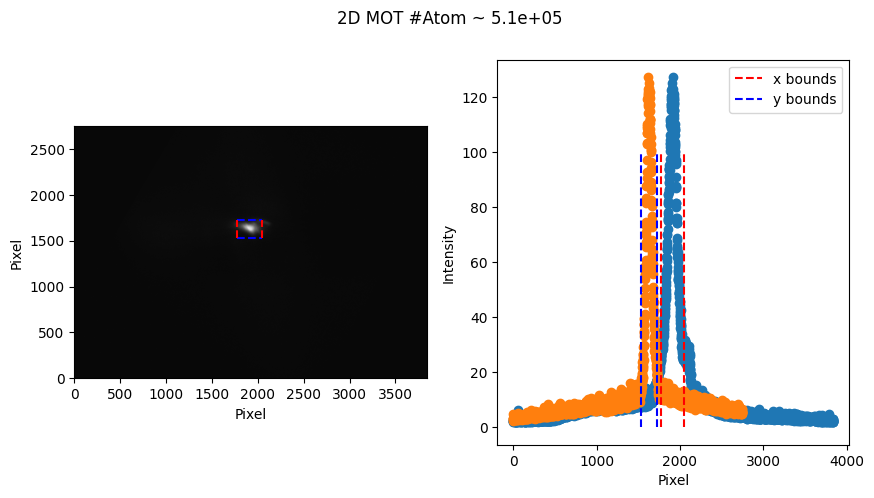

In [8]:
file_path = r'C:\Users\YbII Cobra\Desktop\2D MOT\end fluoro pics\0731/'
file_name = r't_11970_0_us.bmp'



background = True

file_path_bg = file_path
# file_path_bg = r'\Basler_acA3800-14um__24872332__20240716_173302385_0000.bmp'

if background:
    file_name_bg = file_name[:-4] + '_bg.bmp'
    
else:
    file_name_bg = file_name


plotMOTNumber(imageio.imread(file_path + file_name), 
              imageio.imread(file_path_bg + file_name_bg), 
              t_exp = 11970e-6,
              df =  2 * np.pi * 751.5270397e12 + 2.5e6, 
              p = 93e-3, 
              d0 = 395e-3)

C:\Users\YbII Cobra\AppData\Local\Temp\ipykernel_38664\577914824.py:16: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  nums.append(plotMOTNumber(imageio.imread(file_path + file_name),
C:\Users\YbII Cobra\AppData\Local\Temp\ipykernel_38664\577914824.py:17: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  imageio.imread(file_path_bg + file_name_bg),


0.09516255476623316
0.08573993737683037
0.07755428318980508
0.0704156455521506
0.06416524364558422
0.1060482435197974
0.11866361502854092
0.150359241559641
0.1333178272673348


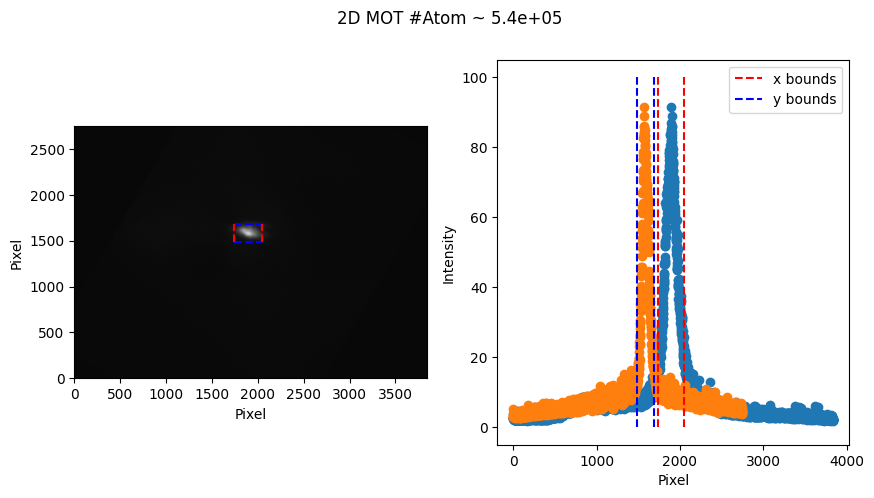

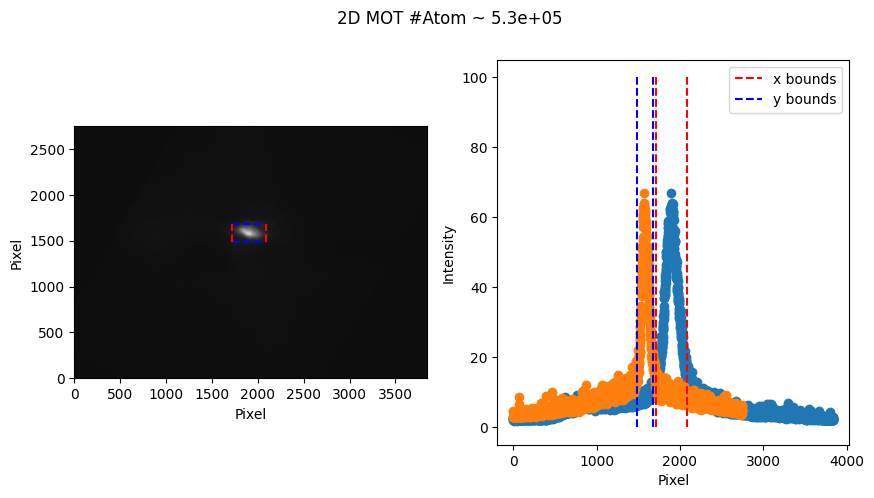

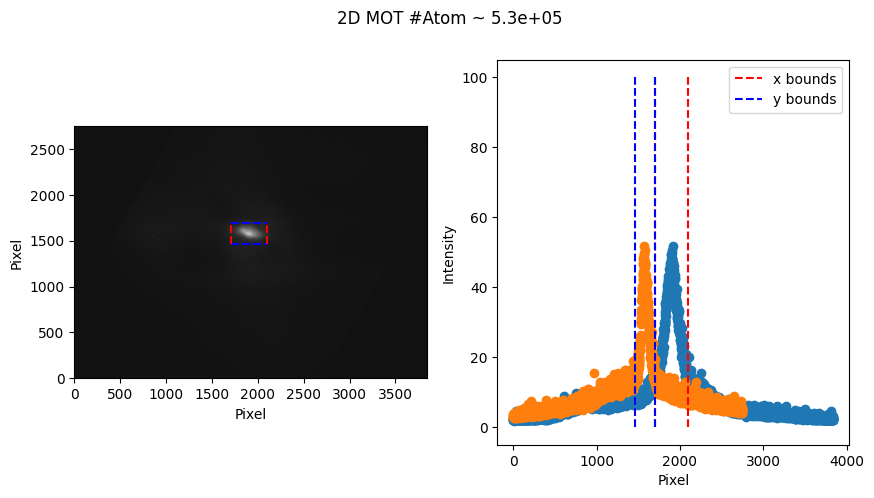

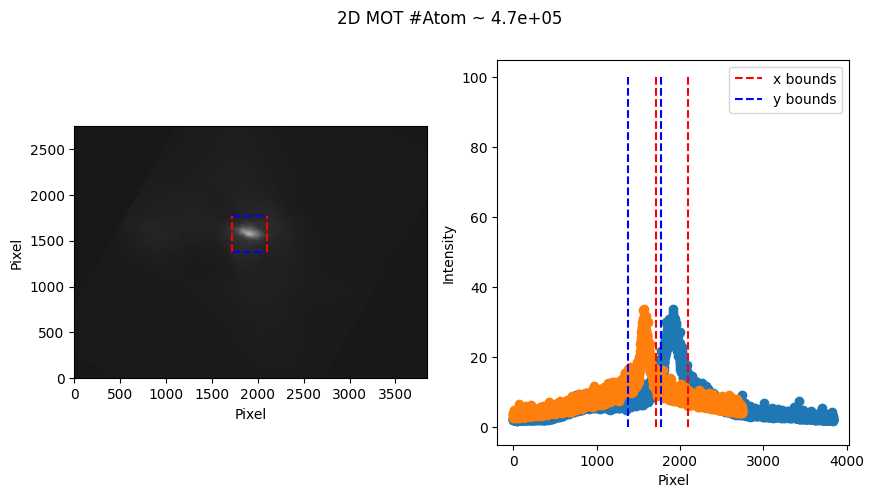

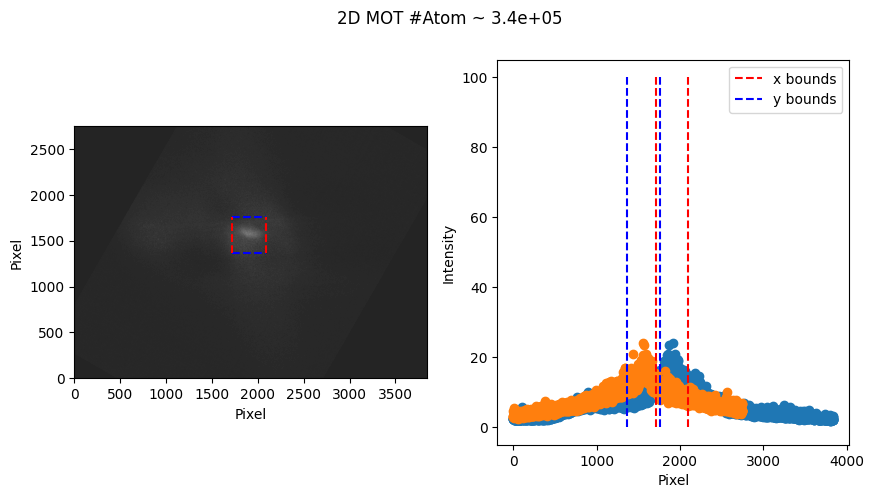

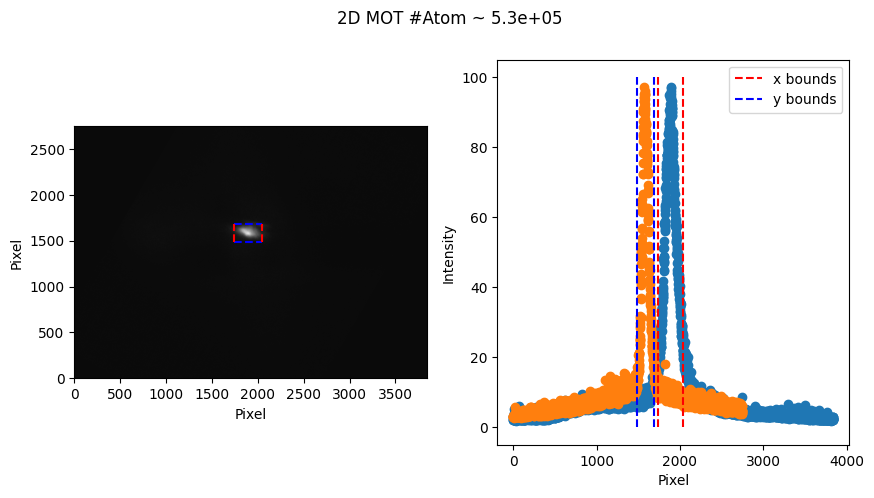

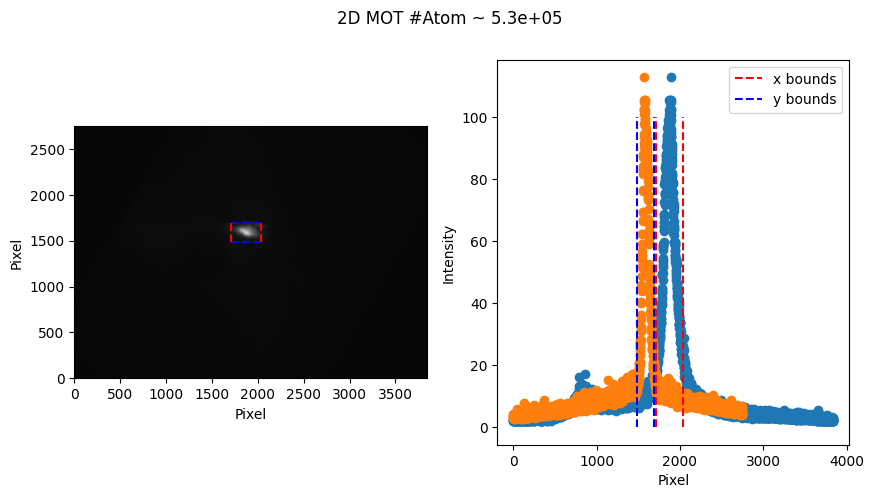

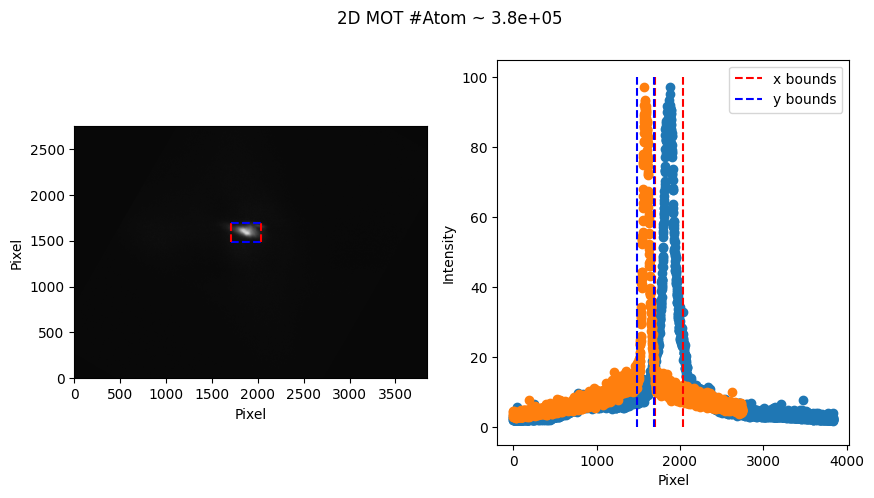

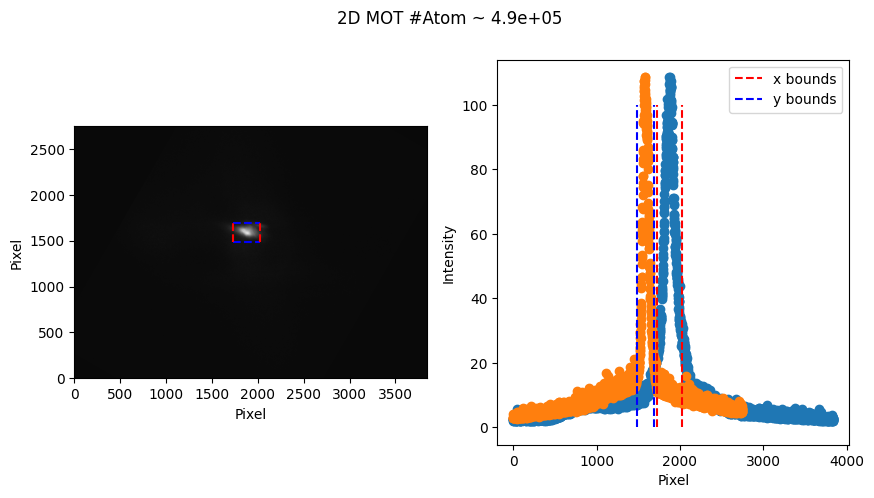

In [38]:
import pandas as pd

file_path = r'C:\Users\YbII Cobra\Desktop\2D MOT\end fluoro pics\0723\freq/'
file_path_bg = file_path

background = True

nums = []

df = pd.read_csv(r'C:\Users\YbII Cobra\Desktop\2D MOT\end fluoro pics\0723\freq\data.csv')

for i in range(len(df)):
    file_name = df['# filename'][i]
    file_name_bg = df['# filename'][i][:-4] + '_bg.bmp'
    # print(file_name, file_name_bg)
    nums.append(plotMOTNumber(imageio.imread(file_path + file_name), 
            imageio.imread(file_path_bg + file_name_bg), 
            t_exp = 11865e-6,
            df =  2 * np.pi * df['f0'][i] + 2 * np.pi * df['df'][i], 
            p = 99e-3, 
            d0 = 395e-3))

In [39]:
print(nums)

[541353.4532026601, 528376.204887856, 526300.4774429172, 467225.95671762223, 338862.5710217489, 531866.453257416, 528509.7780139465, 382171.98300262465, 489050.4389685069]
